# Run DRN

In [45]:
# load data first
%cd /home/ltchen/gnnpp
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import argparse
import json
import pytorch_lightning as L
import torch
import wandb

from models.drn import DRN
from models.model_utils import EmbedStations
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
#from sklearn.preprocessing import StandardScaler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.stats import norm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from utils.data import load_dataframes, summary_statistics
from utils.drn_utils import *
from models.loss import NormalCRPS, crps_no_avg


/home/ltchen/gnnpp


# All stations

In [74]:
DIRECTORY = os.getcwd()
PATH = os.path.join(DIRECTORY, "explored_models")
print(PATH)

/home/ltchen/gnnpp/explored_models


## DRNs (MSE & CRPS) for all stations

In [ ]:
# nn mse loss with lightning
# Deterministic NN with one hidden layer using MSE as loss and embeddings

class MyDRN(L.LightningModule):
    def __init__(self, hidden_size, embedding_dim, in_feat, optimizer_class, optimizer_params):
        super(MyDRN, self).__init__()
        self.embedding = EmbedStations(num_stations_max=122, embedding_dim=embedding_dim)
        self.linear = torch.nn.Linear(in_features=in_feat, out_features=hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_t2m = torch.nn.Linear(in_features=hidden_size, out_features=1)  # output t2m value

        self.loss = torch.nn.MSELoss()
        self.optimizer_class = optimizer_class
        self.optimizer_params = optimizer_params

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print(x.shape) # (8, 65)
        x = self.embedding(x)
        #print(f"After embedding: {x.shape}") # (8, 84)
        x = self.linear(x)
        #print(x.shape) # (8, 64)
        x = self.relu(x)
        #print(x.shape)
        x = self.linear_t2m(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y.flatten())  # why y.flatten()?
        self.log("train_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return self.optimizer_class(self.parameters(), **self.optimizer_params)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y.flatten())
        self.log("validation_loss", loss.item(), on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx, dataloader_idx=0):  # unterschied zwischen predict und test_step?
        x, y = batch  # wieso hat test_step auch y?
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y.flatten())
        self.log("test_loss", loss.item(), on_epoch=True, prog_bar=True)
        return loss


In [47]:
# nn crps loss with lightning
class CRPSDRN(L.LightningModule):
    def __init__(self, embedding_dim, in_channels, hidden_channels, optimizer_class, optimizer_params):
        super(CRPSDRN, self).__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = len(hidden_channels)

        self.embedding = EmbedStations(num_stations_max=122, embedding_dim=embedding_dim)
        self.linear = nn.ModuleList()
        for hidden_size in self.hidden_channels:
            self.linear.append(nn.Linear(in_features=in_channels, out_features=hidden_size))
            in_channels = hidden_size
        self.relu = torch.nn.ReLU()
        self.softplus = torch.nn.Softplus()
        self.last_linear_mu = nn.Linear(in_features=hidden_size, out_features=1)
        self.last_linear_sigma = nn.Linear(in_features=hidden_size, out_features=1)

        self.loss_fn = NormalCRPS()
        self.optimizer_class = optimizer_class
        self.optimizer_params = optimizer_params

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)  #(8, 65)
        for layer in self.linear:
            x = layer(x)
            print(x.shape)
            x = self.relu(x)
            print(x.shape)
        mu = self.last_linear_mu(x)
        x = self.relu(x)  #(8, 64)
        mu = self.last_linear_mu(x)
        sigma = self.softplus(self.last_linear_sigma(x))
        res = torch.cat([mu, sigma], dim=1)
        return res

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn.crps(mu_sigma=y_hat, y=y.flatten())
        self.log("train_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return self.optimizer_class(self.parameters(), **self.optimizer_params)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn.crps(mu_sigma=y_hat, y=y.flatten())
        self.log("validation_loss", loss.item(), on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx, dataloader_idx=0):  # unterschied zwischen predict und test_step?
        x, y = batch  # wieso hat test_step auch y?
        y_hat = self.forward(x)
        loss = self.loss_fn.crps(mu_sigma=y_hat, y=y.flatten())
        self.log("test_loss", loss.item(), on_epoch=True, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, _ = batch
        y_hat = self.forward(x)
        return y_hat


## 24h R2R

### Load dataframes for train, valid, test

In [75]:
dataframes = load_dataframes(mode="train", leadtime="24h") # train mode => for training nn? Wie wird das im Paper beschrieben?
dataframes = summary_statistics(dataframes) # wie sehen die daten von summary statistics aus? => wenn das nur die Daten von einer Station sind, dann über Zeitpunkte
dataframes.pop("stations") # .pop("stations") => entfernt den df mit stations, wofuer brauche ich die dann überhaupt? => equivalent zu GNN

# test
for X, y in dataframes.values(): # wofuer?
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

train, valid_test = normalize_features(
    training_data=dataframes["train"], valid_test_data=[dataframes["test_rf"], dataframes["test_f"]]
)

train = drop_nans(train)
(test_rf, test_f) = valid_test
test_rf = drop_nans(test_rf)
test_f = drop_nans(test_f)

SAVEPATH = os.path.join(PATH, "drn_24h/models")
#print(train[1].isna().sum()) #drop_nans does not work without summary_statistics

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f
[INFO] Normalizing features...


In [76]:
print(SAVEPATH)

/home/ltchen/gnnpp/explored_models/drn_24h/models


In [38]:
# check for nans
nans = train[1]["t2m"].isna().reset_index(drop=True)
print(train[0].index)
print(train[1].index)
#nans.index
#train[0][~nans]
#res = (train[0][~nans], train[1][~nans])
#res

RangeIndex(start=0, stop=4627216, step=1)
RangeIndex(start=0, stop=420656, step=1)


In [3]:
# difference between valid and test - one station only
# train
for i in train:
    print(i.shape)
    print(i.columns)

# valid_test
for (i, j) in valid_test:
    print(i.shape)
    print(i.columns)

(398866, 65)
Index(['station_id', 'model_orography', 'station_altitude', 'station_latitude',
       'station_longitude', 'cape_mean', 'cape_std', 'sd_mean', 'sd_std',
       'stl1_mean', 'stl1_std', 'swvl1_mean', 'swvl1_std', 't2m_mean',
       't2m_std', 'tcc_mean', 'tcc_std', 'tcw_mean', 'tcw_std', 'tcwv_mean',
       'tcwv_std', 'u10_mean', 'u10_std', 'u100_mean', 'u100_std', 'v10_mean',
       'v10_std', 'v100_mean', 'v100_std', 'vis_mean', 'vis_std', 'cp6_mean',
       'cp6_std', 'mn2t6_mean', 'mn2t6_std', 'mx2t6_mean', 'mx2t6_std',
       'p10fg6_mean', 'p10fg6_std', 'slhf6_mean', 'slhf6_std', 'sshf6_mean',
       'sshf6_std', 'ssr6_mean', 'ssr6_std', 'ssrd6_mean', 'ssrd6_std',
       'str6_mean', 'str6_std', 'strd6_mean', 'strd6_std', 'tp6_mean',
       'tp6_std', 'z_mean', 'z_std', 'q_mean', 'q_std', 'u_mean', 'u_std',
       'v_mean', 'v_std', 't_mean', 't_std', 'cos_doy', 'sin_doy'],
      dtype='object')
(398866, 3)
Index(['time', 'station_id', 't2m'], dtype='object')
(89304

In [49]:
# import json file to config
print(SAVEPATH)
CONFIG_FOLDER = os.path.join(DIRECTORY, "trained_models/drn_24h")
JSONPATH = os.path.join(CONFIG_FOLDER, "params.json")

with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
print(args_dict)
config = args_dict
# check if it works, if not: see in drn_eval
'''
@dataclass
class DummyConfig:
    pass

for key, value in args_dict.items():
    setattr(DummyConfig, key, value)

config = DummyConfig()
print("[INFO] Starting eval with config: ", args_dict)
'''
'''params.json
{"leadtime":"24h",
"batch_size":4096,
"lr":0.01,
"hidden_channels": [256],
"max_epochs": 26,
"only_summary": "True"}
'''

/home/ltchen/gnnpp/explored_models/drn_24/models
[INFO] Loading /home/ltchen/gnnpp/trained_models/drn_24h/params.json
{'leadtime': '24h', 'batch_size': 4096, 'lr': 0.01, 'hidden_channels': [256], 'max_epochs': 26, 'only_summary': 'True'}


'params.json\n{"leadtime":"24h",\n"batch_size":4096,\n"lr":0.01,\n"hidden_channels": [256],\n"max_epochs": 26,\n"only_summary": "True"}\n'

### Train DRN

In [50]:
with wandb.init(
    project="reproduction",
    id = f"training_run_24h_crps",
    config=config,
    tags=["exploration"],
):
    config=wandb.config
    y_scaler = StandardScaler(with_std=False) # wieso scalen wir überhaupt? => robuster?
    y_scaler = y_scaler.fit(train[1][["t2m"]])

    #batch_size =2048
    #hidden_size=128
    #lr=0.0002
    #max_epochs=31

    embed_dim = 20
    in_channels = train[0].shape[1] + embed_dim - 1


    train_dataset = TensorDataset(torch.Tensor(train[0].to_numpy()), torch.Tensor(y_scaler.transform(train[1][["t2m"]])))
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    mydrn = CRPSDRN(
        embedding_dim=embed_dim,
        in_channels=in_channels,
        hidden_channels=config.hidden_channels,

        optimizer_class=AdamW,
        optimizer_params=dict(lr=config.lr),
)

    wandb_logger = WandbLogger(project="all_station_crps")

    checkpoint_callback = ModelCheckpoint(
        dirpath=SAVEPATH, filename=f"run_24h", monitor="train_loss", mode="min", save_top_k=1
    )

    trainer = L.Trainer(
        max_epochs=config.max_epochs,
        log_every_n_steps=10,
        accelerator="gpu",
        enable_progress_bar=True,
        enable_model_summary=True,
        logger=wandb_logger,
        callbacks=checkpoint_callback,
)

    trainer.fit(model=mydrn, train_dataloaders=train_loader)

    final_loss = trainer.logged_metrics["train_loss_step"]
    print("Final MSE Loss:", final_loss)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type          | Params | Mode 
-----------

Epoch 0:   0%|          | 0/98 [00:00<?, ?it/s] torch.Size([4096, 256])
torch.Size([4096, 256])
Epoch 0:   1%|          | 1/98 [00:00<00:28,  3.38it/s, v_num=crps, train_loss_step=4.970]torch.Size([4096, 256])
torch.Size([4096, 256])
Epoch 0:   2%|▏         | 2/98 [00:00<00:15,  6.01it/s, v_num=crps, train_loss_step=3.920]torch.Size([4096, 256])
torch.Size([4096, 256])
Epoch 0:   3%|▎         | 3/98 [00:00<00:11,  8.14it/s, v_num=crps, train_loss_step=2.850]torch.Size([4096, 256])
torch.Size([4096, 256])
Epoch 0:   4%|▍         | 4/98 [00:00<00:09,  9.98it/s, v_num=crps, train_loss_step=2.040]torch.Size([4096, 256])
torch.Size([4096, 256])
Epoch 0:   5%|▌         | 5/98 [00:00<00:08, 11.37it/s, v_num=crps, train_loss_step=1.800]torch.Size([4096, 256])
torch.Size([4096, 256])
Epoch 0:   6%|▌         | 6/98 [00:00<00:07, 12.59it/s, v_num=crps, train_loss_step=1.900]torch.Size([4096, 256])
torch.Size([4096, 256])
Epoch 0:   7%|▋         | 7/98 [00:00<00:06, 13.65it/s, v_num=crps, train_lo

`Trainer.fit` stopped: `max_epochs=26` reached.


Epoch 25: 100%|██████████| 98/98 [00:06<00:00, 15.86it/s, v_num=crps, train_loss_step=0.613, train_loss_epoch=0.595]
Final MSE Loss: tensor(0.6131)


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
train_loss_epoch,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▄▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
epoch,25
train_loss_epoch,0.59487
train_loss_step,0.59001
trainer/global_step,2547


### Evaluate

In [53]:
# eval (aber wo ist validate?)
test_rf_dataset = TensorDataset(torch.Tensor(test_rf[0].to_numpy()), torch.Tensor(y_scaler.transform(test_rf[1][["t2m"]])))
test_rf_loader = DataLoader(test_rf_dataset, batch_size=config.batch_size, shuffle=False)

test_f_dataset = TensorDataset(torch.Tensor(test_f[0].to_numpy()), torch.Tensor(y_scaler.transform(test_f[1][["t2m"]])))
test_f_loader = DataLoader(test_f_dataset, batch_size=config.batch_size, shuffle=False)

trainer = L.Trainer(
    log_every_n_steps=1, accelerator="gpu", enable_progress_bar=True, enable_model_summary=False
)
preds_list = []

preds = trainer.predict(model=mydrn, dataloaders=test_f_loader)
preds = torch.cat(preds, dim=0)
# Reverse transform of the y_scaler (only on the mean)
preds[:, 0] = torch.Tensor(y_scaler.inverse_transform(preds[:, 0].view(-1, 1))).flatten()
preds_list.append(preds)

targets = test_f[1] #R2F
print("test_rf[1]:")
print(targets)
targets = torch.Tensor(targets.t2m.values)
print("t2m values:")
print(targets)

stacked = torch.stack(preds_list)
final_preds = torch.mean(stacked, dim=0)
print("final_preds")
print(final_preds)

res = mydrn.loss_fn.crps(final_preds, targets)
print("#############################################")
print("#############################################")
print(f"final crps: {res.item()}")
print("#############################################")
print("#############################################")


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/22 [00:00<?, ?it/s]torch.Size([4096, 256])
torch.Size([4096, 256])
Predicting DataLoader 0:   5%|▍         | 1/22 [00:00<00:00, 286.69it/s]torch.Size([4096, 256])
torch.Size([4096, 256])
Predicting DataLoader 0:   9%|▉         | 2/22 [00:00<00:00, 76.06it/s] torch.Size([4096, 256])
torch.Size([4096, 256])
Predicting DataLoader 0:  14%|█▎        | 3/22 [00:00<00:00, 55.53it/s]torch.Size([4096, 256])
torch.Size([4096, 256])
Predicting DataLoader 0:  18%|█▊        | 4/22 [00:00<00:00, 50.15it/s]torch.Size([4096, 256])
torch.Size([4096, 256])
Predicting DataLoader 0:  23%|██▎       | 5/22 [00:00<00:00, 49.72it/s]torch.Size([4096, 256])
torch.Size([4096, 256])
Predicting DataLoader 0:  27%|██▋       | 6/22 [00:00<00:00, 49.36it/s]torch.Size([4096, 256])
torch.Size([4096, 256])
Predicting DataLoader 0:  32%|███▏      | 7/22 [00:00<00:00, 42.53it/s]torch.Size([4096, 256])
torch.Size([4096, 256])
Predicting DataLoader 0:  36%|███▋      | 8/22 [00:00<

In [80]:
print(SAVEPATH)
# Save Results ##################################################################
# Create DataFrame
df = pd.DataFrame(np.concatenate([targets.view(-1, 1), final_preds], axis=1), columns=["t2m", "mu", "sigma"])
print(df)
df.to_csv(os.path.join(SAVEPATH, f"f_results.csv"), index=False)

/home/ltchen/gnnpp/explored_models/drn_72h/models
              t2m          mu     sigma
0      270.950012  274.584625  2.999041
1      269.649994  273.300598  2.789350
2      272.250000  275.225830  2.582817
3      271.850006  274.528259  3.106495
4      268.049988  271.866760  3.166227
...           ...         ...       ...
86737  273.450012  272.568298  2.313924
86738  273.549988  272.155090  1.762051
86739  272.649994  270.929138  2.533329
86740  266.950012  264.111633  2.804780
86741  266.450012  264.330078  2.876440

[86742 rows x 3 columns]


## 72h R2F

### Load dataframes for train and valie

In [81]:
# dataloader and preprocessing
dataframes = load_dataframes(mode="train", leadtime="72h") # train mode => for training nn? Wie wird das im Paper beschrieben?
dataframes = summary_statistics(dataframes) # wie sehen die daten von summary statistics aus? => wenn das nur die Daten von einer Station sind, dann über Zeitpunkte
dataframes.pop("stations") # .pop("stations") => entfernt den df mit stations, wofuer brauche ich die dann überhaupt? => equivalent zu GNN

# test
for X, y in dataframes.values(): # wofuer?
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

train, valid_test = normalize_features(
    training_data=dataframes["train"], valid_test_data=[dataframes["test_rf"], dataframes["test_f"]]
)

train = drop_nans(train)
(test_rf, test_f) = valid_test
test_rf = drop_nans(test_rf)
test_f = drop_nans(test_f)

DIRECTORY = os.getcwd()
SAVEPATH = os.path.join(PATH, "drn_72h/models")
print(PATH)
print(SAVEPATH)

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f
[INFO] Normalizing features...
/home/ltchen/gnnpp/explored_models
/home/ltchen/gnnpp/explored_models/drn_72h/models


In [59]:
CONFIG_FOLDER = os.path.join(DIRECTORY, "trained_models/drn_72h")
JSONPATH = os.path.join(CONFIG_FOLDER, "params.json")

with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

[INFO] Loading /home/ltchen/gnnpp/trained_models/drn_72h/params.json


### Train

In [60]:
with wandb.init(
    project="reproduction",
    id = f"training_run_72h_crps",
    config=config,
    tags=["exploration"],
):
    config=wandb.config
    y_scaler = StandardScaler(with_std=False) # wieso scalen wir überhaupt? => robuster?
    y_scaler = y_scaler.fit(train[1][["t2m"]])

    #batch_size =2048
    #hidden_size=128
    #lr=0.0002
    #max_epochs=31

    embed_dim = 20
    in_channels = train[0].shape[1] + embed_dim - 1


    train_dataset = TensorDataset(torch.Tensor(train[0].to_numpy()), torch.Tensor(y_scaler.transform(train[1][["t2m"]])))
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    mydrn = CRPSDRN(
        embedding_dim=embed_dim,
        in_channels=in_channels,
        hidden_channels=config.hidden_channels,

        optimizer_class=AdamW,
        optimizer_params=dict(lr=config.lr),
)

    wandb_logger = WandbLogger(project="all_station_crps")

    checkpoint_callback = ModelCheckpoint(
        dirpath=SAVEPATH, filename=f"run_72h", monitor="train_loss", mode="min", save_top_k=1
    )

    trainer = L.Trainer(
        max_epochs=config.max_epochs,
        log_every_n_steps=10,
        accelerator="gpu",
        enable_progress_bar=True,
        enable_model_summary=True,
        logger=wandb_logger,
        callbacks=checkpoint_callback,
)

    trainer.fit(model=mydrn, train_dataloaders=train_loader)

    final_loss = trainer.logged_metrics["train_loss_step"]
    print("Final MSE Loss:", final_loss)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type          | Params | Mode 
-----------

Epoch 0:   0%|          | 0/49 [00:00<?, ?it/s] torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:   2%|▏         | 1/49 [00:00<00:05,  9.58it/s, v_num=crps, train_loss_step=4.900]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:   4%|▍         | 2/49 [00:00<00:09,  4.97it/s, v_num=crps, train_loss_step=4.820]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:   6%|▌         | 3/49 [00:00<00:07,  6.37it/s, v_num=crps, train_loss_step=4.660]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:   8%|▊         | 4/49 [00:00<00:06,  7.47it/s, v_num=crps, train_loss_step=4.490]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:  10%|█         | 5/49 [00:00<00:05,  8.42it/s, v_num=crps, train_loss_step=4.350]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:  12%|█▏        | 6/49 [00:00<00:04,  9.15it/s, v_num=crps, train_loss_step=4.130]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:  14%|█▍        | 7/49 [00:00<00:04,  9.50it/s, v_num=crps, train_lo

`Trainer.fit` stopped: `max_epochs=27` reached.


Epoch 26: 100%|██████████| 49/49 [00:05<00:00,  8.96it/s, v_num=crps, train_loss_step=0.795, train_loss_epoch=0.805]
Final MSE Loss: tensor(0.7950)


epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
train_loss_epoch,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
epoch,26
train_loss_epoch,0.80528
train_loss_step,0.79487
trainer/global_step,1322


### Evaluate

In [61]:
# NN object, train, test
test_rf_dataset = TensorDataset(torch.Tensor(test_rf[0].to_numpy()), torch.Tensor(y_scaler.transform(test_rf[1][["t2m"]])))
test_rf_loader = DataLoader(test_rf_dataset, batch_size=config.batch_size, shuffle=False)

test_f_dataset = TensorDataset(torch.Tensor(test_f[0].to_numpy()), torch.Tensor(y_scaler.transform(test_f[1][["t2m"]])))
test_f_loader = DataLoader(test_f_dataset, batch_size=config.batch_size, shuffle=False)

trainer = L.Trainer(
    log_every_n_steps=1, accelerator="gpu", enable_progress_bar=True, enable_model_summary=False
)
preds_list = []

preds = trainer.predict(model=mydrn, dataloaders=test_f_loader) # R2F
preds = torch.cat(preds, dim=0)
# Reverse transform of the y_scaler (only on the mean)
preds[:, 0] = torch.Tensor(y_scaler.inverse_transform(preds[:, 0].view(-1, 1))).flatten()
preds_list.append(preds)

targets = test_f[1] # R2F
print("test_f[1]:")
print(targets)
targets = torch.Tensor(targets.t2m.values)
print("t2m values:")
print(targets)

stacked = torch.stack(preds_list)
final_preds = torch.mean(stacked, dim=0)
print("final_preds")
print(final_preds)

res = mydrn.loss_fn.crps(final_preds, targets)
print("#############################################")
print("#############################################")
print(f"final crps: {res.item()}")
print("#############################################")
print("#############################################")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/11 [00:00<?, ?it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:   9%|▉         | 1/11 [00:00<00:00, 238.12it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  18%|█▊        | 2/11 [00:00<00:00, 43.56it/s] torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  27%|██▋       | 3/11 [00:00<00:00, 26.54it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  36%|███▋      | 4/11 [00:00<00:00, 25.74it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  45%|████▌     | 5/11 [00:00<00:00, 12.43it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  55%|█████▍    | 6/11 [00:00<00:00, 13.14it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  64%|██████▎   | 7/11 [00:00<00:00, 14.08it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  73%|███████▎  | 8/11 [00:00<

In [85]:
df = pd.DataFrame(np.concatenate([targets.view(-1, 1), final_preds], axis=1), columns=["t2m", "mu", "sigma"])
print(df)
print(os.path.join(SAVEPATH, f"f_results.csv"))
df.to_csv(os.path.join(SAVEPATH, f"f_results.csv"), index=False)

              t2m          mu     sigma
0      270.950012  274.584625  2.999041
1      269.649994  273.300598  2.789350
2      272.250000  275.225830  2.582817
3      271.850006  274.528259  3.106495
4      268.049988  271.866760  3.166227
...           ...         ...       ...
86737  273.450012  272.568298  2.313924
86738  273.549988  272.155090  1.762051
86739  272.649994  270.929138  2.533329
86740  266.950012  264.111633  2.804780
86741  266.450012  264.330078  2.876440

[86742 rows x 3 columns]
/home/ltchen/gnnpp/explored_models/drn_72h/models/f_results.csv


## 120h R2F

### Load dataframes for train and valid

In [68]:
# dataloader and preprocessing
dataframes = load_dataframes(mode="train",
                             leadtime="120h")  # train mode => for training nn? Wie wird das im Paper beschrieben?
dataframes = summary_statistics(
    dataframes)  # wie sehen die daten von summary statistics aus? => wenn das nur die Daten von einer Station sind, dann über Zeitpunkte
dataframes.pop(
    "stations")  # .pop("stations") => entfernt den df mit stations, wofuer brauche ich die dann überhaupt? => equivalent zu GNN

# test
for X, y in dataframes.values():  # wofuer?
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

train, valid_test = normalize_features(
    training_data=dataframes["train"], valid_test_data=[dataframes["test_rf"], dataframes["test_f"]]
)

train = drop_nans(train)
(test_rf, test_f) = valid_test
test_rf = drop_nans(test_rf)
test_f = drop_nans(test_f)

SAVEPATH = os.path.join(PATH, "drn_120h/models")

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f
[INFO] Normalizing features...


In [69]:
CONFIG_FOLDER = os.path.join(DIRECTORY, "trained_models/drn_120h")
JSONPATH = os.path.join(CONFIG_FOLDER, "params.json")

with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

[INFO] Loading /home/ltchen/gnnpp/trained_models/drn_120h/params.json


### Train

In [70]:
with wandb.init(
        project="reproduction",
        id=f"training_run_120h_crps",
        config=config,
        tags=["exploration"],
):
    config = wandb.config
    y_scaler = StandardScaler(with_std=False)  # wieso scalen wir überhaupt? => robuster?
    y_scaler = y_scaler.fit(train[1][["t2m"]])

    #batch_size =2048
    #hidden_size=128
    #lr=0.0002
    #max_epochs=31

    embed_dim = 20
    in_channels = train[0].shape[1] + embed_dim - 1

    train_dataset = TensorDataset(torch.Tensor(train[0].to_numpy()),
                                  torch.Tensor(y_scaler.transform(train[1][["t2m"]])))
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    mydrn = CRPSDRN(
        embedding_dim=embed_dim,
        in_channels=in_channels,
        hidden_channels=config.hidden_channels,

        optimizer_class=AdamW,
        optimizer_params=dict(lr=config.lr),
    )

    wandb_logger = WandbLogger(project="all_station_crps")

    checkpoint_callback = ModelCheckpoint(
        dirpath=SAVEPATH, filename=f"run_120h", monitor="train_loss", mode="min", save_top_k=1
    )

    trainer = L.Trainer(
        max_epochs=config.max_epochs,
        log_every_n_steps=10,
        accelerator="gpu",
        enable_progress_bar=True,
        enable_model_summary=True,
        logger=wandb_logger,
        callbacks=checkpoint_callback,
    )

    trainer.fit(model=mydrn, train_dataloaders=train_loader)

    final_loss = trainer.logged_metrics["train_loss_step"]
    print("Final MSE Loss:", final_loss)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type          | Params | Mode 
-----------

Epoch 0:   0%|          | 0/49 [00:00<?, ?it/s] torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:   2%|▏         | 1/49 [00:00<00:04, 10.28it/s, v_num=crps, train_loss_step=4.900]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:   4%|▍         | 2/49 [00:00<00:03, 11.78it/s, v_num=crps, train_loss_step=4.760]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:   6%|▌         | 3/49 [00:00<00:03, 12.53it/s, v_num=crps, train_loss_step=4.510]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:   8%|▊         | 4/49 [00:00<00:05,  7.65it/s, v_num=crps, train_loss_step=4.410]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:  10%|█         | 5/49 [00:00<00:05,  8.53it/s, v_num=crps, train_loss_step=4.190]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:  12%|█▏        | 6/49 [00:00<00:04,  9.17it/s, v_num=crps, train_loss_step=4.090]torch.Size([8192, 512])
torch.Size([8192, 512])
Epoch 0:  14%|█▍        | 7/49 [00:00<00:04,  9.81it/s, v_num=crps, train_lo

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 49/49 [00:05<00:00,  8.64it/s, v_num=crps, train_loss_step=1.080, train_loss_epoch=1.100]
Final MSE Loss: tensor(1.0795)


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss_epoch,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇███
epoch,19
train_loss_epoch,1.10301
train_loss_step,1.07952
trainer/global_step,979


### Evaluate

In [71]:
# NN object, train, test
test_rf_dataset = TensorDataset(torch.Tensor(test_rf[0].to_numpy()),
                                torch.Tensor(y_scaler.transform(test_rf[1][["t2m"]])))
test_rf_loader = DataLoader(test_rf_dataset, batch_size=config.batch_size, shuffle=False)

test_f_dataset = TensorDataset(torch.Tensor(test_f[0].to_numpy()), torch.Tensor(y_scaler.transform(test_f[1][["t2m"]])))
test_f_loader = DataLoader(test_f_dataset, batch_size=config.batch_size, shuffle=False)

trainer = L.Trainer(
    log_every_n_steps=1, accelerator="gpu", enable_progress_bar=True, enable_model_summary=False
)
preds_list = []

preds = trainer.predict(model=mydrn, dataloaders=test_f_loader) #R2F
preds = torch.cat(preds, dim=0)
# Reverse transform of the y_scaler (only on the mean)
preds[:, 0] = torch.Tensor(y_scaler.inverse_transform(preds[:, 0].view(-1, 1))).flatten()
preds_list.append(preds)

targets = test_f[1] # R2F
print("test_rf[1]:")
print(targets)
targets = torch.Tensor(targets.t2m.values)
print("t2m values:")
print(targets)

stacked = torch.stack(preds_list)
final_preds = torch.mean(stacked, dim=0)
print("final_preds")
print(final_preds)

res = mydrn.loss_fn.crps(final_preds, targets)
print("#############################################")
print("#############################################")
print(f"final crps: {res.item()}")
print("#############################################")
print("#############################################")


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/11 [00:00<?, ?it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:   9%|▉         | 1/11 [00:00<00:00, 271.05it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  18%|█▊        | 2/11 [00:00<00:00, 43.36it/s] torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  27%|██▋       | 3/11 [00:00<00:00, 34.11it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  36%|███▋      | 4/11 [00:00<00:00, 31.33it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  45%|████▌     | 5/11 [00:00<00:00, 13.28it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  55%|█████▍    | 6/11 [00:00<00:00, 14.28it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  64%|██████▎   | 7/11 [00:00<00:00, 15.16it/s]torch.Size([8192, 512])
torch.Size([8192, 512])
Predicting DataLoader 0:  73%|███████▎  | 8/11 [00:00<

In [72]:
df = pd.DataFrame(np.concatenate([targets.view(-1, 1), final_preds], axis=1), columns=["t2m", "mu", "sigma"])
print(df)
print(os.path.join(PATH, f"f_results.csv"))
df.to_csv(os.path.join(PATH, f"f_results.csv"), index=False)

              t2m          mu     sigma
0      270.950012  274.584625  2.999041
1      269.649994  273.300598  2.789350
2      272.250000  275.225830  2.582817
3      271.850006  274.528259  3.106495
4      268.049988  271.866760  3.166227
...           ...         ...       ...
86737  273.450012  272.568298  2.313924
86738  273.549988  272.155090  1.762051
86739  272.649994  270.929138  2.533329
86740  266.950012  264.111633  2.804780
86741  266.450012  264.330078  2.876440

[86742 rows x 3 columns]
explored_models/drn_72h/f_results.csv


## One Station

In [25]:
# train
one_station_X = train[0][train[0]["station_id"]==1]
one_station_y = train[1][train[1]["station_id"]==1]

one_station_X = one_station_X.drop("station_id", axis=1)
one_station_y = one_station_y.drop("station_id", axis=1)

print(one_station_X)
print(one_station_X.shape)
print(one_station_y.shape)

# test_rf
s1_test_rf_X = test_rf[0][test_rf[0]["station_id"]==1]
s1_test_rf_y = test_rf[1][test_rf[1]["station_id"]==1]

s1_test_rf_X = s1_test_rf_X.drop("station_id", axis=1)
s1_test_rf_y = s1_test_rf_y.drop("station_id", axis=1)

# test_f
s1_test_f_X = test_f[0][test_f[0]["station_id"]==1]
s1_test_f_y = test_f[1][test_f[1]["station_id"]==1]

s1_test_f_X = s1_test_f_X.drop("station_id", axis=1)
s1_test_f_y = s1_test_f_y.drop("station_id", axis=1)

        model_orography  station_altitude  station_latitude  \
1             -0.737002           -0.7786          1.016052   
123           -0.737002           -0.7786          1.016052   
245           -0.737002           -0.7786          1.016052   
367           -0.737002           -0.7786          1.016052   
489           -0.737002           -0.7786          1.016052   
...                 ...               ...               ...   
420047        -0.737002           -0.7786          1.016052   
420169        -0.737002           -0.7786          1.016052   
420291        -0.737002           -0.7786          1.016052   
420413        -0.737002           -0.7786          1.016052   
420535        -0.737002           -0.7786          1.016052   

        station_longitude  cape_mean  cape_std   sd_mean    sd_std  stl1_mean  \
1                -0.89124  -0.164696 -0.233030 -0.138945 -0.130389  -0.465046   
123              -0.89124  -0.127184 -0.138486 -0.138945 -0.130389  -0.443237   


### One Station MSE and CRPS NNs
Station (station_id=1) with one hidden layer and loss functions MSE or CRPS

In [30]:
class MSEStationNN(L.LightningModule):
    def __init__(self, in_feat, hidden_size, optimizer_class, optimizer_params):
        super(MSEStationNN, self).__init__()
        self.linear = torch.nn.Linear(in_features=in_feat, out_features=hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_t2m = torch.nn.Linear(in_features=hidden_size, out_features=1)

        self.loss = torch.nn.MSELoss()
        self.optimizer_class = optimizer_class
        self.optimizer_params = optimizer_params

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear_t2m(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y.flatten())
        self.log("train_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return self.optimizer_class(self.parameters(), **self.optimizer_params)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y.flatten())
        return loss

    def test_step(self, batch, batch_idx, dataloader_idx=0): # unterschied zwischen predict und test_step?
        x, y = batch # wieso hat test_step auch y? => um score zu berechnen
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y.flatten())
        return loss


In [31]:
class CRPSStationNN(L.LightningModule):
    def __init__(self, in_feat, hidden_size, optimizer_class, optimizer_params):
        super(CRPSStationNN, self).__init__()
        self.linear = torch.nn.Linear(in_features=in_feat, out_features=hidden_size)
        self.relu = torch.nn.ReLU()
        #self.linear_t2m = torch.nn.Linear(in_features=hidden_size, out_features=2) => wieso nicht direkt 2 outputs?
        self.softplus = torch.nn.Softplus()
        self.last_linear_mu = nn.Linear(in_features=hidden_size, out_features=1)
        self.last_linear_sigma = nn.Linear(in_features=hidden_size, out_features=1)

        self.loss_fn = NormalCRPS()
        self.optimizer_class = optimizer_class
        self.optimizer_params = optimizer_params

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)
        x = self.relu(x)
        mu = self.last_linear_mu(x)
        sigma = self.softplus(self.last_linear_sigma(x))
        res = torch.cat([mu, sigma], dim=1)
        return res

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn.crps(mu_sigma=y_hat, y=y.flatten())
        self.log("train_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return self.optimizer_class(self.parameters(), **self.optimizer_params)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn.crps(mu_sigma=y_hat, y=y.flatten())
        return loss

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn.crps(mu_sigma=y_hat, y=y.flatten())
        print(f'test_loss: {loss}')
        return {'loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, _ = batch
        y_hat = self.forward(x)
        return y_hat


### Train One Station NN (MSE or CRPS)

In [32]:
with wandb.init(
    project="exploration",
    id = f"training_run_24h_crps",
    tags=["exploration"],
):

    y_scaler = StandardScaler(with_std=False) # wieso scalen wir überhaupt? => robuster?
    y_scaler = y_scaler.fit(one_station_y[["t2m"]])

    batch_size = 512
    hidden_size=128
    lr=0.0002
    max_epochs=31
    in_feat = one_station_X.shape[1]

    one_station_train_ds = TensorDataset(torch.Tensor(one_station_X.to_numpy()), torch.Tensor(y_scaler.transform(one_station_y[["t2m"]])))
    one_station_loader = DataLoader(one_station_train_ds, batch_size=batch_size, shuffle=True)

    s1_test_rf_ds = TensorDataset(torch.Tensor(s1_test_rf_X.to_numpy()), torch.Tensor(y_scaler.transform(s1_test_rf_y[["t2m"]])))
    s1_test_rf_loader = DataLoader(s1_test_rf_ds, batch_size=batch_size, shuffle=False)

    one_station_nn = CRPSStationNN(
        in_feat=in_feat,
        hidden_size=hidden_size,
        optimizer_class=AdamW,
        optimizer_params={"lr": lr}
    )

    wandb_logger = WandbLogger(project="one_station_crps")

    os_checkpoint_callback = ModelCheckpoint(
        dirpath=SAVEPATH, filename=f"run_24h", monitor="train_loss", mode="min", save_top_k=1
    )

    one_station_trainer = L.Trainer(
        max_epochs=max_epochs,
        log_every_n_steps=1,
        accelerator="gpu",
        enable_model_summary=True,
        logger=wandb_logger,
        callbacks=os_checkpoint_callback,
    )

    value = one_station_trainer.fit(model=one_station_nn, train_dataloaders=one_station_loader)

    final_loss = one_station_trainer.logged_metrics["train_loss_step"] # nochmal step und epoch nachschauen
    print("Final MSE Loss:", final_loss)


# wo finde ich den tatsaechlichen wert? => bei test, jetzt wird nur das Modell trainiert

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: C

Epoch 30: 100%|██████████| 7/7 [00:00<00:00, 57.77it/s, v_num=crps, train_loss_step=1.320, train_loss_epoch=1.280]

`Trainer.fit` stopped: `max_epochs=31` reached.


Epoch 30: 100%|██████████| 7/7 [00:00<00:00, 52.44it/s, v_num=crps, train_loss_step=1.320, train_loss_epoch=1.280]
Final MSE Loss: tensor(1.3195)


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,███▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_loss_step,█▇██▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
epoch,30
train_loss_epoch,1.28279
train_loss_step,1.31945
trainer/global_step,216


### Validate and test one station NN (MSE and CRPS)

In [33]:
# validation and test for both mse and crps
s1_test_f_ds = TensorDataset(torch.Tensor(s1_test_f_X.to_numpy()), torch.Tensor(y_scaler.transform(s1_test_f_y[["t2m"]])))
s1_test_f_loader = DataLoader(s1_test_f_ds, batch_size=batch_size, shuffle=False)

loss = one_station_trainer.test(model=one_station_nn, dataloaders=s1_test_f_loader)
print(loss)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 225.69it/s]
[{}]


# Other

## Plot PIT Histogram

In [65]:
# where is the data saved for my drn_run from Moritz Data
# implement data saving first

FOLDER = "explored_models"
MODEL = "drn_72h"
PATH = os.path.join(FOLDER, MODEL)
DATASET = "f"

predictions = pd.read_csv(os.path.join(PATH, f"{DATASET}_results.csv"))
predictions = predictions.dropna(axis=0)

y = torch.tensor(predictions["t2m"].to_numpy())
preds = torch.tensor(predictions[["mu", "sigma"]].to_numpy())


In [41]:
# my data
print(PATH)
predictions = pd.read_csv(os.path.join(PATH, f"{DATASET}_results.csv"))
predictions = predictions.dropna(axis=0)

y = torch.tensor(predictions["t2m"].to_numpy())
preds = torch.tensor(predictions[["mu", "sigma"]].to_numpy())


trained_models/drn_24h


In [36]:
# average crps
y = predictions["t2m"].to_numpy()
print(y)
print(y.shape)
mu = predictions["mu"].to_numpy()
print(mu)
print(mu.shape)
sigma = predictions["sigma"].to_numpy()
print(sigma)
print(sigma.shape)

normalCRPS = NormalCRPS()

err = normalCRPS.crps(mu_sigma=torch.tensor(predictions[["mu", "sigma"]].to_numpy()), y=torch.tensor(predictions["t2m"].to_numpy())).item()
err

[270.95 269.65 272.25 ... 272.65 266.95 266.45]
(86742,)
[275.24017 274.0299  275.51523 ... 271.93604 265.34274 265.3213 ]
(86742,)
[3.1376274 2.861889  2.5845995 ... 2.8419755 2.932102  2.9322085]
(86742,)


1.0985086007802476

In [ ]:
# PIT Histogram for raw data (use summary statistics for mu and sigma)
# empirische Verteilung => PIT values ableiten - rank histogram



Text(0.5, 0, 'PIT value')

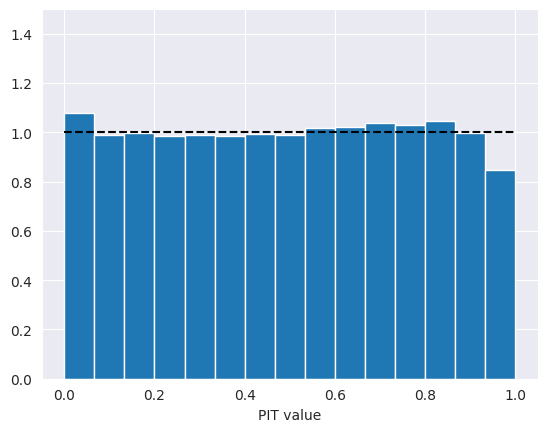

In [29]:
# PIT Histogram for this trained model 24h
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=15, density=True)

# colors
#cm = get_color(MODEL)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

#for c, p in zip(col, patches):
    #plt.setp(p, 'facecolor', cm(c))


plt.ylim(0,1.5)  # Layout
plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")
plt.xlabel('PIT value')

Text(0.5, 0, 'PIT value')

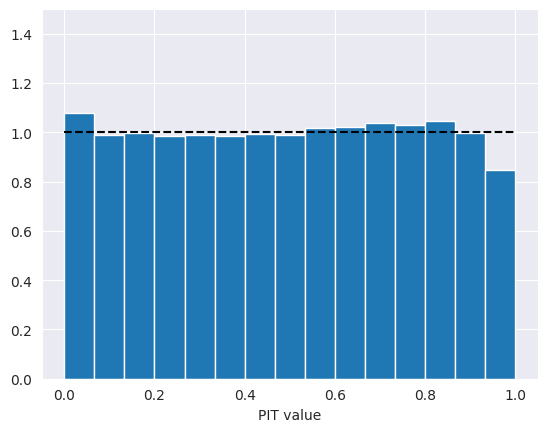

In [37]:
# PIT for 72h
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=15, density=True)

# colors
#cm = get_color(MODEL)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

#for c, p in zip(col, patches):
    #plt.setp(p, 'facecolor', cm(c))


plt.ylim(0,1.5)  # Layout
plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")
plt.xlabel('PIT value')

Text(0.5, 0, 'PIT value')

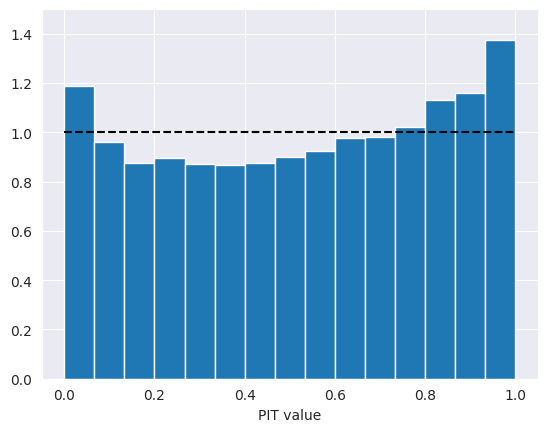

In [61]:
# PIT for 120h
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=15, density=True)

# colors
#cm = get_color(MODEL)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

#for c, p in zip(col, patches):
    #plt.setp(p, 'facecolor', cm(c))


plt.ylim(0,1.5)  # Layout
plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")
plt.xlabel('PIT value')

## MyDRN without wandb and without saving

In [19]:
# MyDRN train without wandb without saving

y_scaler = StandardScaler(with_std=False)
y_scaler = y_scaler.fit(train[1][["t2m"]])


train_dataset = TensorDataset(
    torch.Tensor(train[0].to_numpy()), torch.Tensor(y_scaler.transform(train[1][["t2m"]]))
)

#from params.json best_24h
batch_size = 2048
hidden_size=128
lr=0.0002
max_epochs=31

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

embed_dim = 20
in_feat = train[0].shape[1] + embed_dim - 1

mydrn = MyDRN(
    hidden_size=hidden_size,
    embedding_dim=embed_dim,
    in_feat=in_feat,
    optimizer_class=AdamW,
    optimizer_params=dict(lr=lr),
)

checkpoint_callback = ModelCheckpoint(
    # dirpath=SAVEPATH, filename=f"run_{args.id}", monitor="train_loss", mode="min", save_top_k=1
    dirpath=SAVEPATH, filename=f"run_24h", monitor="train_loss", mode="min", save_top_k=1
)

trainer = L.Trainer(
    max_epochs=max_epochs,
    log_every_n_steps=50,
    accelerator="gpu",
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=checkpoint_callback,
)

trainer.fit(model=mydrn, train_dataloaders=train_loader)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-package

Epoch 0:   3%|▎         | 5/195 [00:00<00:05, 32.69it/s, v_num=28, train_loss_step=42.50]

/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([2048])) that is different to the input size (torch.Size([2048, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1:   3%|▎         | 5/195 [00:00<00:05, 34.61it/s, v_num=28, train_loss_step=41.90, train_loss_epoch=41.20]  

/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1554])) that is different to the input size (torch.Size([1554, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 30: 100%|██████████| 195/195 [00:05<00:00, 37.23it/s, v_num=28, train_loss_step=39.70, train_loss_epoch=41.20]

`Trainer.fit` stopped: `max_epochs=31` reached.


Epoch 30: 100%|██████████| 195/195 [00:05<00:00, 37.21it/s, v_num=28, train_loss_step=39.70, train_loss_epoch=41.20]


## DRN with given DRN

In [37]:
# with given models - funktioniert fuer summary statistics, aber nicht ohne? => woran liegt das?
# => weil targets (y) einen actual Wert pro station besitzen und X noch 11 ensemble member pro Station hat
DIRECTORY = os.getcwd()
JSONPATH = os.path.join(DIRECTORY, "trained_models/drn_24h/params.json")
SAVEPATH = os.path.join(DIRECTORY, "trained_models/drn_24h/models")

with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)

with wandb.init(
    project="multigraph",
    # id=f"training_run_drn_{args_dict['leadtime']}_{args.id}",
    id = f"training_run_{args_dict['leadtime']}",
    config=args_dict,
    tags=["final_training"],
):
    config=wandb.config
    dataframes = load_dataframes(mode="train", leadtime=config.leadtime)
    dataframes = summary_statistics(dataframes)
    dataframes.pop("stations")

    # print(list(dataframes.values()))
    for df in dataframes.values():
        print(type(df))

    for X, y in dataframes.values():
        X.reset_index(drop=True, inplace=True)
        y.reset_index(drop=True, inplace=True)

    train, valid_test = normalize_features(
        training_data=dataframes["train"], valid_test_data=[dataframes["test_rf"], dataframes["test_f"]]
    )

    print(f"dataframes['train']: {dataframes['train']}")
    print(f"train: {train}")

    train = drop_nans(train)

    y_scaler = StandardScaler(with_std=False)
    y_scaler = y_scaler.fit(train[1][["t2m"]])

    train_dataset = TensorDataset(
        torch.Tensor(train[0].to_numpy()), torch.Tensor(y_scaler.transform(train[1][["t2m"]]))
    )

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    embed_dim = 20 # why 20? => embed stations - instead of station_id - map into a latent vector space
    in_channels = train[0].shape[1] + embed_dim - 1

    drn = DRN(
        in_channels=in_channels,
        hidden_channels=config.hidden_channels,
        embedding_dim=embed_dim,
        optimizer_class=AdamW,
        optimizer_params=dict(lr=config.lr),
    )
    wandb_logger = WandbLogger(project="multigraph")
    checkpoint_callback = ModelCheckpoint(
        # dirpath=SAVEPATH, filename=f"run_{args.id}", monitor="train_loss", mode="min", save_top_k=1
        dirpath=SAVEPATH, filename=f"run_24h", monitor="train_loss", mode="min", save_top_k=1
    )
    trainer = L.Trainer(
        max_epochs=config.max_epochs,
        log_every_n_steps=1,
        accelerator="gpu",
        enable_progress_bar=True,
        enable_model_summary=True,
        logger=wandb_logger,
        callbacks=checkpoint_callback,
    )
    trainer.fit(model=drn, train_dataloaders=train_loader)


[INFO] Loading /home/ltchen/gnnpp/trained_models/drn_24h/params.json


[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
[INFO] Normalizing features...


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/ltchen/.conda/envs/gnn_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: C

dataframes['train']: (        station_id  model_orography  station_altitude  station_latitude  \
0                0        -0.738289         -0.764101          1.382904   
1                1        -0.737002         -0.778600          1.016052   
2                2        -0.731851         -0.733171          1.571141   
3                3        -0.728793         -0.765712          1.661951   
4                4        -0.724769         -0.761846          0.884948   
...            ...              ...               ...               ...   
420651         117         0.914135          0.298485         -2.911765   
420652         118         1.443053          0.598123         -1.881973   
420653         119         2.338639          0.646451         -2.021799   
420654         120         4.799571          3.994016         -2.028314   
420655         121         5.913903          4.345205         -2.201382   

        station_longitude  cape_mean  cape_std   sd_mean    sd_std  stl1_mean

`Trainer.fit` stopped: `max_epochs=26` reached.


Epoch 25: 100%|██████████| 98/98 [00:05<00:00, 17.92it/s, v_num=_24h, train_loss_step=0.580, train_loss_epoch=0.597]


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇████
train_loss_epoch,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▄▄▄▃▃▃▂▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▃▂▂▂▂▂▁▁▂▁▂▂▁▂▁▂
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch,25
train_loss_epoch,0.59687
train_loss_step,0.58027
trainer/global_step,2547


In [51]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
